In [134]:
# Imports
import random
import scipy
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics
% matplotlib inline

In [3]:
class DataLoader:
    """
    Class for loading the MatLab data.
    """

    def __init__(self, file):
        """
        Load the data from the given file.

        :param file: Path to file to load the data from (without the .mat extension).
        :param flip_rate: Rate for flipping bits randomly, 0 means no flipping and 1 means all flipped and the
                          maximum entropy is obtained for flip_rate = 0.5.
        """
        self.data = scipy.io.loadmat(file, squeeze_me=True, struct_as_record=False)['mnist']
        self.train_images = self.data.train_images
        self.test_images = self.data.test_images
        self.train_labels = self.data.train_labels
        self.test_labels = self.data.test_labels

    def load_images(self, flip_rate=0):
        self.train_images = self.transform_images(self.train_images)
        self.test_images = self.transform_images(self.test_images)
        if flip_rate > 0:
            noise = np.random.binomial(1, flip_rate, self.train_images.shape) * -2 + 1
            self.train_images = np.multiply(self.train_images, noise)

    def transform_images(self, data):
        """
        Convert a (m x n x p) array to a (p x m x n) array and apply some additional transformations.

        :param data: Data to transform.
        :return: Transformed data.
        """
        reshaped = data.reshape(data.shape[0] * data.shape[1], data.shape[2])
        swapped_axes = np.swapaxes(reshaped, 0, 1)
        return (swapped_axes > 122) * 2 - 1

In [7]:
num_neurons = 28 * 28
learning_rate = 0.01
w = np.random.normal(0, 1, (num_neurons, num_neurons))
theta = np.random.normal(0, 1, (num_neurons,))
np.fill_diagonal(w, 1)

In [10]:
data = DataLoader('mnistAll')
data.load_images(0.1)

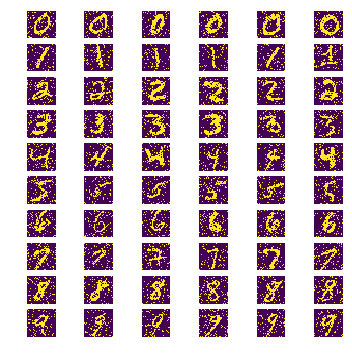

In [33]:
f, ax = plt.subplots(10, 6, figsize=(6, 6))

for digit in range(0, 10):
    samples = data.train_images[data.train_labels == digit]
    for sample in range(0, 6):
        ax[digit][sample].imshow(samples[sample, :].reshape(28, 28))
        ax[digit][sample].axis('off')

In [55]:
def calculate_probabilities(samples, w, theta, normalizing_constant):
    return np.exp(-calculate_energy(samples, w, theta)) / normalizing_constant

def calculate_energy(samples, w, theta):
    f = np.dot(samples, np.dot(w, samples.T))
    # Also allow samples consisting of one sample (an array, so f.ndim == 1)
    # Therefore, only take the diagonal in the two dimensional case
    if f.ndim == 2:
        f = np.diagonal(f)
    return np.squeeze(np.asarray(-0.5 * f - np.dot(theta.T, samples.T)))

In [56]:
training_samples = data.train_images[data.train_labels == 2]

In [129]:
def train_classifiers(samples, labels):
    w = np.zeros((10, 28 * 28, 28 * 28))
    theta = np.zeros((10, 28 * 28))
    Z = np.zeros(10)
    for digit in range(0, 10):
        training_samples = samples[labels == digit]
        s_mean_clamped = np.squeeze(np.asarray(np.mean(training_samples, 0)))
        s_cov_clamped = np.cov(training_samples.T)
        m = s_mean_clamped
        C = s_cov_clamped - np.dot(np.asmatrix(s_mean_clamped).T, np.asmatrix(s_mean_clamped))
        delta = np.zeros(s_cov_clamped.shape)
        np.fill_diagonal(delta, 1. / (1. - np.multiply(m, m)))
        w[digit, :, :] = delta - np.linalg.inv(C)
        theta[digit, :] = np.arctanh(m) - np.dot(w[digit, :, :], m)
        F = -0.5 * np.dot(np.dot(m, w[digit, :, :]), m) - np.dot(theta[digit, :], m) + 0.5 * np.dot(1 + m, np.log(0.5 * (1 + m))) + 0.5 * np.dot(1 - m, np.log(0.5 * (1 - m)))
        Z[digit] = np.exp(-F)
    return w, theta, Z

w, theta, Z = train_classifiers(data.train_images, data.train_labels)

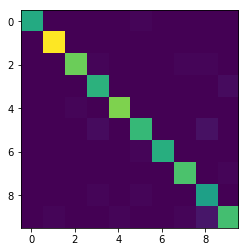

In [130]:
X = data.test_images

num_samples = 500
probabilities = np.zeros((10, num_samples))
for digit in range(0, 10):
    probabilities[digit, :] = calculate_probabilities(X[:num_samples, :], w[digit, :, :], theta[digit, :], Z[digit])
    
predicted = np.argmax(probabilities, axis=0)
real = data.test_labels[:num_samples]

cm = confusion_matrix(real, predicted)
plt.imshow(cm)
plt.show()

In [132]:
metrics.accuracy_score(real, predicted)

0.95399999999999996

In [133]:
cm.diagonal() / cm.sum(axis=1)

array([ 0.97619048,  1.        ,  0.94545455,  0.95555556,  0.98181818,
        0.9       ,  0.97674419,  0.97959184,  0.95      ,  0.87037037])

# Research question
Which noise level yields the lowest accuracy?

In [ ]:
noise_levels = np.arange(0.05, 0.55, 0.05)
accuracy = []

X = data.test_images
rounds = 10
num_samples = 500
accuracy = np.zeros((len(noise_levels), rounds))
for k in range(rounds):
    print('Round: ', k)
    for noise_index, noise_level in enumerate(noise_levels):
        print('Noise level: ', noise_level)
        perm = np.random.permutation(X.shape[0])
        data = DataLoader('mnistAll')
        data.load_images(noise_level)
        w, theta, Z = train_classifiers(data.train_images, data.train_labels)

        probabilities = np.zeros((10, num_samples))
        for digit in range(0, 10):
            probabilities[digit, :] = calculate_probabilities(X[perm[:num_samples], :], w[digit, :, :], theta[digit, :], Z[digit])

        predicted = np.argmax(probabilities, axis=0)
        real = data.test_labels[perm[:num_samples]]

        accuracy[noise_index, k] = metrics.accuracy_score(real, predicted)

Round:  0
Noise level:  0.05
Noise level:  0.1
Noise level:  0.15
Noise level:  0.2
Noise level:  0.25
Noise level:  0.3
Noise level:  0.35
Noise level:  0.4
Noise level:  0.45
Noise level:  0.5
Round:  1
Noise level:  0.05
Noise level:  0.1
Noise level:  0.15


[[ 1.    0.98  0.94  0.92  0.92  0.88  0.94  0.98  0.96  0.88]
 [ 0.98  0.96  0.98  0.96  0.98  0.96  0.98  0.96  0.96  0.98]
 [ 0.98  1.    0.98  0.96  0.96  0.92  0.88  0.92  0.94  0.92]
 [ 0.96  0.98  0.96  0.98  1.    0.96  0.98  0.98  0.96  0.98]
 [ 0.92  0.94  0.92  0.96  0.9   0.98  0.98  0.98  0.9   0.96]
 [ 0.96  0.96  0.94  0.96  0.96  1.    0.96  0.98  0.92  0.94]
 [ 0.88  0.9   0.96  0.98  0.84  0.98  0.94  0.96  0.9   1.  ]
 [ 0.94  0.88  0.88  0.92  0.94  0.88  0.88  0.96  0.92  0.92]
 [ 0.88  0.88  0.82  0.9   0.9   0.88  0.82  0.88  0.94  0.84]]


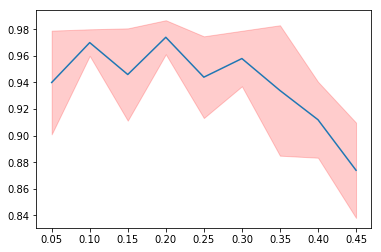

In [240]:
print(accuracy)
mean_accuracy = np.mean(accuracy, axis=1)
plt.plot(noise_levels, mean_accuracy)
error = np.std(accuracy, axis=1)
plt.fill_between(noise_levels,mean_accuracy - error, mean_accuracy + error, alpha=0.2, edgecolor='#FF0000', facecolor='#FF0000')

In [178]:
def generate_samples(s, w, theta, num_burn_in=50, num_samples=500, show_transition_probabilities=False):
    num_neurons = w.shape[0]
    
    # Initialize the matrix of generated samples
    X = np.empty((0, num_neurons))
    
    # Iterate (first generate some samples during the burn-in period and then gather the samples)
    for iteration in range(num_samples):
        for burn_in in range(num_burn_in + 1):
            # Store the original value of s
            s_original = s
            # Calculate the flip probabilities
            p_flip = 0.5 * (1 + np.tanh(np.multiply(-s, np.dot(w, s) + theta)))
            # Calculate transition probabilities
            p_transition = p_flip / float(num_neurons)
            p_stay = 1 - np.sum(p_transition)
            # Flip according to the probability distribution of flipping
            if random.random() <= 1 - p_stay:
                # Pick a random neuron
                neuron = random.randint(1, num_neurons) - 1
                if random.random() <= p_flip[neuron]:
                    s[neuron] *= -1
            # Add the state if the sample is not generated during the burn in period
            if burn_in >= num_burn_in:
                if show_transition_probabilities:
                    print('Transition probabilities for ', s_original,':', p_transition, ' (stay probability: ', p_stay, ')')
                X = np.vstack([X, s])
    return X

In [218]:
data = DataLoader('mnistAll')
data.load_images(0.2)
w, theta, Z = train_classifiers(data.train_images, data.train_labels)

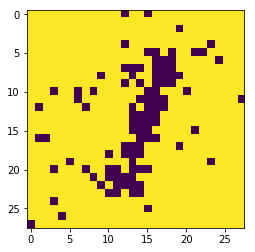

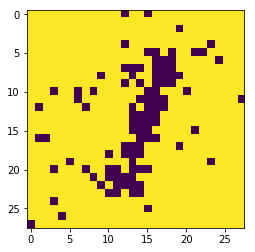

In [230]:
from IPython import display
import time

digit = 1

#s = theta[digit, :]
#s = s + np.random.normal(0, 0.001, s.shape)
#s[s > 0] = 1
#s[s < 0] = -1
s = np.ones((28 * 28,))
for i in range(100):
    samples = generate_samples(s, w[digit, :, :], theta[digit, :], 500, 1)
    s = samples[0, :]
    plt.imshow(samples[samples.shape[0] - 1, :].reshape(28, 28))
    display.clear_output(wait=True)
    display.display(plt.gcf())
    time.sleep(0.1)